In [9]:
import pandas as pd
import numpy as np
import re, random
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, pipeline


import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import datasets 
import evaluate


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
print(torch.__version__)

2.5.1+cu124


# Load data

In [3]:
data_train = pd.read_csv('my_train.csv') 
data_test = pd.read_csv('my_test.csv')
data_val= pd.read_csv('my_val.csv')

In [4]:
data_train.head(2)

,Unnamed: 0,sentiment,text
0,12588,1,two rooms packed and cleaned three to go
1,1079,0,_nation just launched twittix v1 10 not convinced


In [5]:
# remove Unnamed:0 and use label instead of sentiment
train_df = pd.DataFrame({
    "label": data_train.sentiment.values,
    "text": data_train.text.values
})

val_df = pd.DataFrame({
    "label": data_val.sentiment.values,
    "text": data_val.text.values
})

test_df = pd.DataFrame({
    "label": data_test.sentiment.values,
    "text": data_test.text.values
})

## Create Dataset objects

In [6]:
# create DATASETs

train_df = datasets.Dataset.from_dict(train_df)
val_df = datasets.Dataset.from_dict(val_df)
test_df = datasets.Dataset.from_dict(test_df)

In [7]:
# Create DATASET DICT
dataset_dict = datasets.DatasetDict({"train":train_df, "valid":val_df, "test":test_df})

In [8]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 18968
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2108
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5270
    })
})

# Pre training objective
- ARCHITECTURE : ENCODER block + DECODER block
- Understand and represent the language **BIDIRECTIONALLY**: BERT mimics this by looking at words both before and after (BIDIRECTIONAL) the target word. This bidirectional approach allows BERT to capture richer context compared to models that only look at previous words.
![WHat Bidirectional mean?](https://sushant-kumar.com/blog/bert-bidirectional.png)


In [10]:
model_name = "google-bert/bert-base-uncased" 

In [11]:
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
#we want to return our tokenizer over our examples text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [13]:
# we can apply tokenize function over our dataset dictionary
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/18968 [00:00<?, ? examples/s]

Map:   0%|          | 0/2108 [00:00<?, ? examples/s]

Map:   0%|          | 0/5270 [00:00<?, ? examples/s]

In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18968
    })
    valid: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2108
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5270
    })
})

In [15]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(9000))
small_eval_dataset = tokenized_datasets["valid"].shuffle(seed=42).select(range(1000))

# Fine Tune our model

In [17]:
NUM_LABELS = 3
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                       num_labels = NUM_LABELS, 
                                                       id2label = {0: 'negative', 1: 'neutral', 2: 'positive'})

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
metric = evaluate.load("accuracy")

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references = labels)

In [20]:
training_args = TrainingArguments(output_dir = "test_trainer", eval_strategy = "epoch", num_train_epochs = 3)

In [21]:
trainer = Trainer(
    model = model, 
    args = training_args,
    train_dataset = small_train_dataset,
    eval_dataset = small_eval_dataset,
    compute_metrics = compute_metrics)

In [22]:
trainer.train()

  0%|          | 0/3375 [00:00<?, ?it/s]

{'loss': 0.7292, 'grad_norm': 4.109575271606445, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}
{'loss': 0.6103, 'grad_norm': 9.020120620727539, 'learning_rate': 3.518518518518519e-05, 'epoch': 0.89}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.574861466884613, 'eval_accuracy': 0.79, 'eval_runtime': 3.9316, 'eval_samples_per_second': 254.347, 'eval_steps_per_second': 31.793, 'epoch': 1.0}
{'loss': 0.4774, 'grad_norm': 6.187866687774658, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}
{'loss': 0.4224, 'grad_norm': 10.304298400878906, 'learning_rate': 2.037037037037037e-05, 'epoch': 1.78}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.5736145377159119, 'eval_accuracy': 0.776, 'eval_runtime': 3.8899, 'eval_samples_per_second': 257.076, 'eval_steps_per_second': 32.135, 'epoch': 2.0}
{'loss': 0.361, 'grad_norm': 1.4104712009429932, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}
{'loss': 0.2653, 'grad_norm': 49.215877532958984, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.8969982266426086, 'eval_accuracy': 0.792, 'eval_runtime': 3.9203, 'eval_samples_per_second': 255.083, 'eval_steps_per_second': 31.885, 'epoch': 3.0}
{'train_runtime': 499.3623, 'train_samples_per_second': 54.069, 'train_steps_per_second': 6.759, 'train_loss': 0.4550088116681134, 'epoch': 3.0}


TrainOutput(global_step=3375, training_loss=0.4550088116681134, metrics={'train_runtime': 499.3623, 'train_samples_per_second': 54.069, 'train_steps_per_second': 6.759, 'total_flos': 1776015569664000.0, 'train_loss': 0.4550088116681134, 'epoch': 3.0})

# Evaluate the model

In [21]:
trainer.evaluate()

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.8097333908081055,
 'eval_accuracy': 0.784,
 'eval_runtime': 12.1402,
 'eval_samples_per_second': 82.371,
 'eval_steps_per_second': 10.296,
 'epoch': 3.0}

# Save our model

In [23]:
model.save_pretrained("fine_tuned_model_bert_sentiment3")

In [24]:
fine_tuned_model = BertForSequenceClassification.from_pretrained("fine_tuned_model_bert_sentiment3")

In [25]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use cuda:0


In [26]:
data_test= data_test[['sentiment','text']]
data_test.head(1)

,sentiment,text
0,0,_gates am also gutted the end is nigh x


In [27]:
data_test.rename(columns={'sentiment': 'label'}, inplace=True)

In [30]:
answer = clf(data_test['text'].iloc[0],top_k=None)#[0]['label']
answer[0]['label']

'negative'

In [31]:
data_test.index

RangeIndex(start=0, stop=5270, step=1)

In [36]:
#data_test['label_predicted']= [str(clf(data_test['text'].iloc[x], top_k=None)[0]['label']) for x in data_test.index ]
data_test['label_predicted'] = data_test['text'].apply(lambda x : clf(x, top_k=None)[0]['label'])

In [37]:
data_test.head()

,label,text,label_predicted
0,0,_gates am also gutted the end is nigh x,negative
1,1,i m in a pub garden its boiling hannah no likey,negative
2,0,good work i ve only just managed to turn my s...,positive
3,0,have you noticed that we re at the beginning ...,negative
4,1,there are wonderful people in my life who i th...,positive


In [38]:
mapping = {'negative':0,'neutral':1, 'positive':2}
# Remap values using map() function
data_test['label_predicted'] = data_test['label_predicted'].map(mapping)
data_test.head()

,label,text,label_predicted
0,0,_gates am also gutted the end is nigh x,0
1,1,i m in a pub garden its boiling hannah no likey,0
2,0,good work i ve only just managed to turn my s...,2
3,0,have you noticed that we re at the beginning ...,0
4,1,there are wonderful people in my life who i th...,2


# See the metrics

In [40]:
accuracy = accuracy_score(data_test['label'], data_test['label_predicted'])
round(accuracy,3)

0.784

Classification_report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1792
           1       0.70      0.70      0.70      1731
           2       0.85      0.83      0.84      1747

    accuracy                           0.78      5270
   macro avg       0.78      0.78      0.78      5270
weighted avg       0.78      0.78      0.78      5270

Confusion Matrix


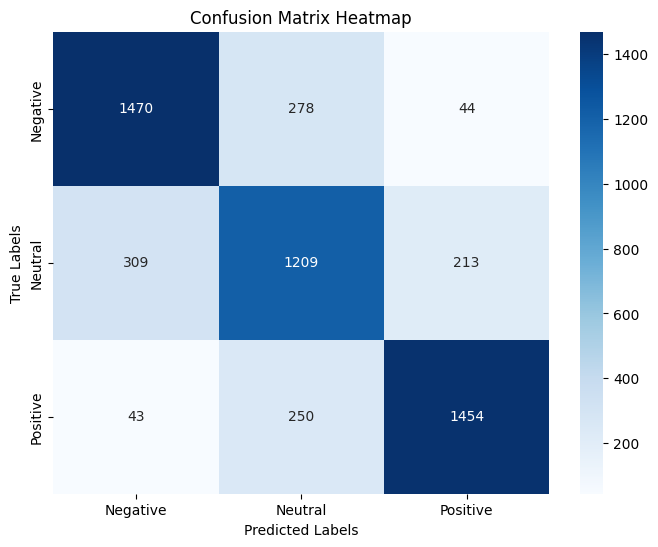

In [41]:
y_test, y_pred= data_test['label'], data_test['label_predicted']

accuracy_score(y_test,y_pred)
print(f'Classification_report')
print(classification_report(y_test,y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Bibliography

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding, 2018](https://arxiv.org/abs/1810.04805)
